### Required Imports

In [157]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [153]:
# Check if the "GPU/CUDA" is available, If Yes, make the default device as GPU (for faster calculations)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Required to download the data and genearte train/test datasets

In [147]:
torch.manual_seed(1) # To make sure that the same splitting/shuffling is done everytime.
batch_size = 256  #batch size of 256 (images) to be loaded at once.
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {} # keyword arguments that can be used while loading the data.


# DataLoader API to get the datasets loaded (as a generator/iterable). This way
# train_loader and test_loader can be used to load the data in batches. 
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


# test_loader to load the data(images, labels) in batches
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


### Plotting the MNIST data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images shape:  torch.Size([256, 1, 28, 28])


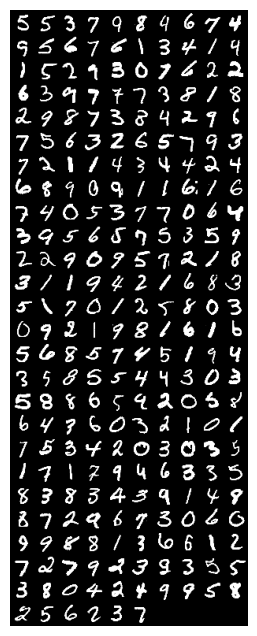

In [158]:
for im, la in train_loader:
    print('images shape: ', im.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(im, nrow=10).permute(1,2,0))
    break

In [159]:
class Model(nn.Module):
    '''
    This Model architecture is used to solve the assignment.
    Contains the following layers:
        2 convolutional layers
        1 MaxPooling layers
        2 Linear/Fully connected layers
        2 Batch Normalization layers
        1 Dropout Layer
        1 Global Average Pooling Layer
    Inputs:
        Image : 1x28x28 (MNIST Image)
    
    Outputs:
        label: Label of the MNIST Image
    
    '''
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),# Input MNIST (1x28x28) image, output: 28x28x16
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2), #14x14x32
            
            nn.Conv2d(64, 32, 3, padding=1), # shape: 14x14x64
            nn.ReLU(),
            nn.BatchNorm2d(32)
            
        ) #output : 14x14x64
    
        self.fc = nn.Sequential(
            nn.Dropout(0.1),   # adding dropout layer with p=0.1
            nn.Linear(32, 12),
            nn.Linear(12, 10)   # final FC layer, to get the classification output.
        )
                
        
    def forward(self, x):
        x = self.conv1(x) # Initial pass of the data throught first Conv1 block
        x = nn.AvgPool2d(14)(x) # We shall be using Global Average Pooling instead of the flatten layer.
        x = torch.squeeze(x)
        x = torch.squeeze(x)
        x = self.fc(x)
        
        x = F.log_softmax(x, dim=1) #final classification output.
        return x


In [149]:
model = Model().to(device) #Initialize the model and move it to the GPU/CUDA.
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
              ReLU-2           [-1, 64, 28, 28]               0
       BatchNorm2d-3           [-1, 64, 28, 28]             128
         MaxPool2d-4           [-1, 64, 14, 14]               0
            Conv2d-5           [-1, 32, 14, 14]          18,464
              ReLU-6           [-1, 32, 14, 14]               0
       BatchNorm2d-7           [-1, 32, 14, 14]              64
           Dropout-8                   [-1, 32]               0
            Linear-9                   [-1, 12]             396
           Linear-10                   [-1, 10]             130
Total params: 19,822
Trainable params: 19,822
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.39
Params size (MB): 0.08
Estimated Tot

In [150]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    '''Function to train the model.'''
    
    # Force the model to be in the training mode.
    model.train()
    pbar = tqdm(train_loader)
    
    # Loop over the data iterator and sample a batch of images and labels
    for batch_idx, (data, target) in enumerate(pbar):
        
        #Move the data and the labels to the device: GPU/CUDA
        data, target = data.to(device), target.to(device)
        
        # Make the gradients of the optimizer to the zero
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        
        # Calcuate the loss
        loss = F.nll_loss(output, target)
        
        # Backward pass and the optimization part.
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    '''Function to evaluate/test the model.'''
    
    #Force the model in the testing/evaluation mode
    model.eval()
    
    # Variables to compute the total loss and the accuracy
    test_loss = 0
    correct = 0
    
    # Use no_grad() context manager, as we don't want to track for backpropagation!!
    with torch.no_grad():
        
        # Loop through the test data loader
        for data, target in test_loader:
            
            # Move the data and labels to the device: GPU/CUDA
            data, target = data.to(device), target.to(device)
            
            # Get the predictions from the model.
            output = model(data)
            
            # compute the loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            
            # Get the label index.
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    # Get the loss and the accuracy values.
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Training the model

In [151]:
# Optimizer for back-propagation!
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model for 20 epochs!
for epoch in range(0, 20):
    train(model, device, train_loader, optimizer, epoch)



loss=0.007101322989910841 batch_id=234: 100%|████████████████████████████████████████| 235/235 [00:08<00:00, 28.00it/s]


### Testing the model

In [152]:

# Test the model
test(model, device, test_loader)


Test set: Average loss: 0.0555, Accuracy: 9831/10000 (98%)

